# Νευρωνικά Δίκτυα και Ευφυή Συστήματα - Άσκηση 3
## Μέρος 2 - Μεταφορά Μάθησης
Ομάδα M.A.2

Βόσινας Κωνσταντίνος     ΑΜ : 03116435

Δαβαράκης Θεοδωρής       ΑΜ : 03115002

Θεοδοσίου Ιωάννης        ΑΜ : 03115056


Import των απαρίτητων βιβλιοθηκών και της έκδοσης 2.1 του TensorFlow.

In [ ]:
!sudo pip install --upgrade pip
!sudo pip install --upgrade tensorflow

     |████████████████████████████████| 1.4MB 8.7MB/s 
  Found existing installation: pip 19.3.1
    Uninstalling pip-19.3.1:
      Successfully uninstalled pip-19.3.1
Requirement already up-to-date: tensorflow in /usr/local/lib/python3.6/dist-packages (2.1.0)


In [ ]:
%tensorflow_version 2.x

TensorFlow 2.x selected.


In [ ]:
from __future__ import absolute_import, division, print_function, unicode_literals # legacy compatibility

import tensorflow as tf
from tensorflow.keras import datasets, layers, models

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

Παρακάτω παρουσιάζουμε τις συναρτήσεις που μας δόθηκαν με την βοήθεια των οποίων φτιάχνουμε το dataset

In [ ]:
# helper functions

# select from from_list elements with index in index_list
def select_from_list(from_list, index_list):
  filtered_list= [from_list[i] for i in index_list]
  return(filtered_list)

# append in filtered_list the index of each element of unfilterd_list if it exists in in target_list
def get_ds_index(unfiliterd_list, target_list):
  index = 0
  filtered_list=[]
  for i_ in unfiliterd_list:
    if i_[0] in target_list:
      filtered_list.append(index)
    index += 1
  return(filtered_list)

# select a url for a unique subset of CIFAR-100 with 20, 40, 60, or 80 classes
def select_classes_number(classes_number = 20):
  cifar100_20_classes_url = "https://pastebin.com/raw/nzE1n98V"
  cifar100_40_classes_url = "https://pastebin.com/raw/zGX4mCNP"
  cifar100_60_classes_url = "https://pastebin.com/raw/nsDTd3Qn"
  cifar100_80_classes_url = "https://pastebin.com/raw/SNbXz700"
  if classes_number == 20:
    return cifar100_20_classes_url
  elif classes_number == 40:
    return cifar100_40_classes_url
  elif classes_number == 60:
    return cifar100_60_classes_url
  elif classes_number == 80:
    return cifar100_80_classes_url
  else:
    return -1

Αρχικά φορτώνουμε όλο το cifar100 dataset

In [ ]:
# load the entire dataset
(x_train_all, y_train_all), (x_test_all, y_test_all) = tf.keras.datasets.cifar100.load_data(label_mode='fine')

169009152/169001437 [==============================] - 6s 0us/step


In [ ]:
# REPLACE WITH YOUR TEAM NUMBER
team_seed = 2

Επιλέγουμε αριθμό κλάσεων 20 για να εκτελέσουμε ολο τα πειράματα μας και στο τέλος εξετάζουμε την επίπτωση που έχει η αλλαγή των κλάσεων σε 40,60 και 80 ξανατρέχοντας το notebook και τεστάροντας μονο το τελευταίο inception model.

In [ ]:
# select the number of classes
cifar100_classes_url = select_classes_number()

Με βάση το seed μας φτιάχνουμε το μοναδικό μας dataset.

In [ ]:
team_classes = pd.read_csv(cifar100_classes_url, sep=',', header=None)
CIFAR100_LABELS_LIST = pd.read_csv('https://pastebin.com/raw/qgDaNggt', sep=',', header=None).astype(str).values.tolist()[0]

our_index = team_classes.iloc[team_seed,:].values.tolist()
our_classes = select_from_list(CIFAR100_LABELS_LIST, our_index)
train_index = get_ds_index(y_train_all, our_index)
test_index = get_ds_index(y_test_all, our_index)

x_train_ds = np.asarray(select_from_list(x_train_all, train_index))
y_train_ds = np.asarray(select_from_list(y_train_all, train_index))
x_test_ds = np.asarray(select_from_list(x_test_all, test_index))
y_test_ds = np.asarray(select_from_list(y_test_all, test_index))

In [ ]:
# print our classes
print(our_classes)

[' aquarium_fish', ' bee', ' bowl', ' boy', ' butterfly', ' cattle', ' clock', ' dinosaur', ' dolphin', ' kangaroo', ' lizard', ' pine_tree', ' plate', ' possum', ' ray', ' table', ' telephone', ' television', ' whale', ' worm']


Κανονικοποιούμε τα δεδομένα και τυπώνουμε ένα δείγμα αυτών για να έχουμε μια εποπτεία της μορφής τους.

Train: X=(8500, 32, 32, 3), y=(8500, 1)
Validation: X=(1500, 32, 32, 3), y=(1500, 1)
Test: X=(2000, 32, 32, 3), y=(2000, 1)


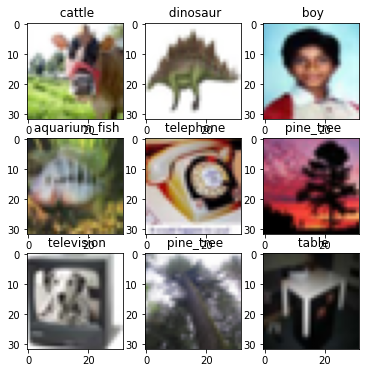

In [ ]:
# get (train) dataset dimensions
data_size, img_rows, img_cols, img_channels = x_train_ds.shape

# set validation set percentage (wrt the training set size)
validation_percentage = 0.15
val_size = round(validation_percentage * data_size)

# Reserve val_size samples for validation and normalize all values
x_val = x_train_ds[-val_size:]/255
y_val = y_train_ds[-val_size:]
x_train = x_train_ds[:-val_size]/255
y_train = y_train_ds[:-val_size]
x_test = x_test_ds/255
y_test = y_test_ds

# summarize loaded dataset
print('Train: X=%s, y=%s' % (x_train.shape, y_train.shape))
print('Validation: X=%s, y=%s' % (x_val.shape, y_val.shape))
print('Test: X=%s, y=%s' % (x_test.shape, y_test.shape))

# get class label from class index
def class_label_from_index(fine_category):
  return(CIFAR100_LABELS_LIST[fine_category.item(0)])

# plot first few images
plt.figure(figsize=(6, 6))
for i in range(9):
	# define subplot
  plt.subplot(330 + 1 + i).set_title(class_label_from_index(y_train[i]))
	# plot raw pixel data
  plt.imshow(x_train[i], cmap=plt.get_cmap('gray'))
  #show the figure
plt.show()

Δημιουργία Dataset και συνάρτηση training μοντέλου.

In [ ]:
# we user prefetch https://www.tensorflow.org/api_docs/python/tf/data/Dataset#prefetch 
# see also AUTOTUNE
# the dataset is now "infinite"

BATCH_SIZE = 128
AUTOTUNE = tf.data.experimental.AUTOTUNE # https://www.tensorflow.org/guide/data_performance

def _input_fn(x,y, BATCH_SIZE):
  ds = tf.data.Dataset.from_tensor_slices((x,y))
  ds = ds.shuffle(buffer_size=data_size)
  ds = ds.repeat()
  ds = ds.batch(BATCH_SIZE)
  ds = ds.prefetch(buffer_size=AUTOTUNE)
  return ds

train_ds =_input_fn(x_train,y_train, BATCH_SIZE) #PrefetchDataset object
validation_ds =_input_fn(x_val,y_val, BATCH_SIZE) #PrefetchDataset object
test_ds =_input_fn(x_test,y_test, BATCH_SIZE) #PrefetchDataset object


# steps_per_epoch and validation_steps for training and validation: https://www.tensorflow.org/guide/keras/train_and_evaluate

def train_model(model1, validation, train, epochs = 10, steps_per_epoch = 2, validation_steps = 1):
  history = model1.fit(train, epochs=epochs, steps_per_epoch=steps_per_epoch, validation_data=validation, validation_steps=validation_steps)
  return(history)

Resized datasets για μοντέλα που δέχονται δαφορετικά μεγέθη εικόνων.

In [ ]:
train_ds_224=train_ds.map(lambda x,y: (tf.image.resize(x, [224,224]), y))
val_ds_224=validation_ds.map(lambda x,y: (tf.image.resize(x, [224,224]), y))
test_ds_224=test_ds.map(lambda x,y: (tf.image.resize(x, [224,224]), y))
train_ds_299=train_ds.map(lambda x,y: (tf.image.resize(x, [299,299]), y))
val_ds_299=validation_ds.map(lambda x,y: (tf.image.resize(x, [299,299]), y))
test_ds_299=test_ds.map(lambda x,y: (tf.image.resize(x, [299,299]), y))

datasets = [[train_ds, validation_ds, test_ds], [train_ds_224, val_ds_224, test_ds_224, train_ds_224], [train_ds_299, val_ds_299, test_ds_299, train_ds_299]]

Συναρτήσεις παρουσίασης των αποτελεσμάτων.

In [ ]:
# plot diagnostic learning curves
def summarize_diagnostics(history, model_name):
	plt.figure(figsize=(8, 8))
	plt.suptitle('Training Curves for model ' + model_name)
	# plot loss
	plt.subplot(211)
	plt.title('Cross Entropy Loss')
	plt.plot(history.history['loss'], color='blue', label='train')
	plt.plot(history.history['val_loss'], color='orange', label='val')
	plt.legend(loc='upper right')
	# plot accuracy
	plt.subplot(212)
	plt.title('Classification Accuracy')
	plt.plot(history.history['accuracy'], color='blue', label='train')
	plt.plot(history.history['val_accuracy'], color='orange', label='val')
	plt.legend(loc='lower right')
	return plt
 
# print test set evaluation metrics
def model_evaluation(model1, evaluation_steps,test_dataset):
	print('\nTest set evaluation metrics')
	loss0,accuracy0 = model1.evaluate(test_dataset, steps = evaluation_steps)
	print("loss: {:.2f}".format(loss0))
	print("accuracy: {:.2f}".format(accuracy0))

def model_report(model, history,test_dataset, model_name, evaluation_steps = 10):
	plt = summarize_diagnostics(history, model_name)
	plt.show()
	model_evaluation(model, evaluation_steps, test_dataset)

Παιρνουμε ως όρισμα ενα προεκπαιδευμένο μοντέλο και επιστρέφουμε ενα επαυξημένο με κάποια επιπλέον επίπεδα μοντέλο.Ως επιπλέον παραμέτρους περνάμε τα επίπεδα που θέλουμε να είναι trainable.

In [ ]:
def init_model(model_base, extra_layers, base_train=False, finetune_layers=0, learning_rate=0.00005, summary=False):
  # unfreeze conv layers
  model_base.trainable=base_train

  if (base_train==False):
    for i in range(len(model_base.layers)-finetune_layers,len(model_base.layers)):
      model_base.layers[i].trainable=True

  dropout_layer = tf.keras.layers.Dropout(rate = 0.5)
  global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
  prediction_layer = tf.keras.layers.Dense(len(CIFAR100_LABELS_LIST),activation='softmax')
  # add top layer for CIFAR100 classification


  if (extra_layers==1):
    model = tf.keras.Sequential([model_base, dropout_layer, global_average_layer,prediction_layer])
  elif (extra_layers==2):
    added_layer_1=tf.keras.layers.Dense(100,activation='relu')
    model = tf.keras.Sequential([model_base, dropout_layer, global_average_layer, added_layer_1,prediction_layer])
  elif (extra_layers==3):
    added_layer_1=tf.keras.layers.Dense(512,activation='relu')
    added_layer_2=tf.keras.layers.Dense(128,activation='relu')
    model = tf.keras.Sequential([model_base, dropout_layer, global_average_layer, added_layer_1,added_layer_2,prediction_layer])



  
  model.compile(optimizer=tf.optimizers.Adam(learning_rate=0.00005), loss=tf.keras.losses.sparse_categorical_crossentropy, metrics=["accuracy"])
  if summary: 
    model.summary()
  return model

Εισάγουμε κάποια προεκαπιδευμένα μοντέλα  για να ώστε να τα χρησιμοποιήσουμε στη συνέχεια για μεταφορά μάθησης.

In [ ]:
from keras import applications


Using TensorFlow backend.


In [ ]:
VGG16_MODEL=tf.keras.applications.VGG16(input_shape=(img_rows, img_cols, img_channels), include_top=False, weights='imagenet')
VGG19_MODEL=tf.keras.applications.VGG19(input_shape=(img_rows, img_cols, img_channels), include_top=False, weights='imagenet')
mobilenet_MODEL=tf.keras.applications.MobileNet(input_shape=(224, 224, 3), include_top=False, weights='imagenet')
densenet_model=tf.keras.applications.DenseNet121(input_shape=(img_rows, img_cols, img_channels), include_top=False, weights='imagenet')
inception_model=tf.keras.applications.InceptionV3(input_shape=(299, 299, 3), include_top=False, weights='imagenet')
NasNet=tf.keras.applications.NASNetMobile(input_shape=(224, 224, 3), include_top=False, weights='imagenet')


models = []
dimensions = [32, 32, 224, 32, 299, 224]
models.append(VGG16_MODEL)
models.append(VGG19_MODEL)
models.append(mobilenet_MODEL)
models.append(densenet_model)
models.append(inception_model)
models.append(NasNet)

datasetIndex = [0, 0, 1, 0, 2, 1]
modelNames = ['VGG16', 'VGG19', 'MobileNet', 'DenseNet', 'Inception', 'NasNet']

19996672/19993432 [==============================] - 1s 0us/step


Δημιουργούμε τις λίστες με τις παραμέτρους που θα εκτελέσουμε πειράματα.

In [ ]:
l_rate=[0.1, 0.01, 0.001, 0.0001, 0.00001,]
n_classes=[20, 40, 60, 80]
additional_layers=[1, 2, 3]
fine_tune_last=[1, 2, 3, 4, 5]

Συνάρτηση που εφαρμόζεται πάνω στη λίστα με τα προεκπαιδευμένα μοντέλα που έχουμε εισάγει και τα εκπαιδεύει/τεστάρει με κάποιες deafault αρχικά τιμές.

In [ ]:
def test_default_models():
  histories = []
  compiled_models = []
  for i in range(len(models)):
    mod = models[i]
    dim = dimensions[i]
    mymodel=init_model(mod, extra_layers=1, base_train=False, finetune_layers=4, learning_rate=0.00005, summary=False)
    history = train_model(mymodel, datasets[datasetIndex[i]][1] , datasets[datasetIndex[i]][0], epochs=300)
    histories.append(history)
    compiled_models.append(mymodel)

  return (compiled_models, histories)

Train for 2 steps, validate for 1 steps
Epoch 1/300
2/2 [==============================] - 7s 4s/step - loss: 5.1396 - accuracy: 0.0117 - val_loss: 4.7534 - val_accuracy: 0.0000e+00
Epoch 2/300
2/2 [==============================] - 0s 66ms/step - loss: 5.0939 - accuracy: 0.0117 - val_loss: 4.8287 - val_accuracy: 0.0000e+00
Epoch 3/300
2/2 [==============================] - 0s 62ms/step - loss: 5.0690 - accuracy: 0.0039 - val_loss: 4.7925 - val_accuracy: 0.0000e+00
Epoch 4/300
2/2 [==============================] - 0s 57ms/step - loss: 5.0277 - accuracy: 0.0195 - val_loss: 4.8041 - val_accuracy: 0.0000e+00
Epoch 5/300
2/2 [==============================] - 0s 61ms/step - loss: 4.9982 - accuracy: 0.0078 - val_loss: 4.7513 - val_accuracy: 0.0000e+00
Epoch 6/300
2/2 [==============================] - 0s 57ms/step - loss: 5.0446 - accuracy: 0.0156 - val_loss: 4.7507 - val_accuracy: 0.0000e+00
Epoch 7/300
2/2 [==============================] - 0s 62ms/step - loss: 4.9807 - accuracy: 0.0117 

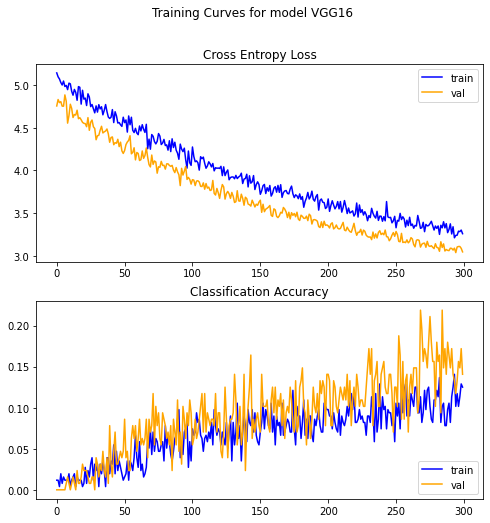


Test set evaluation metrics
10/10 [==============================] - 0s 26ms/step - loss: 3.0695 - accuracy: 0.1453
loss: 3.07
accuracy: 0.15


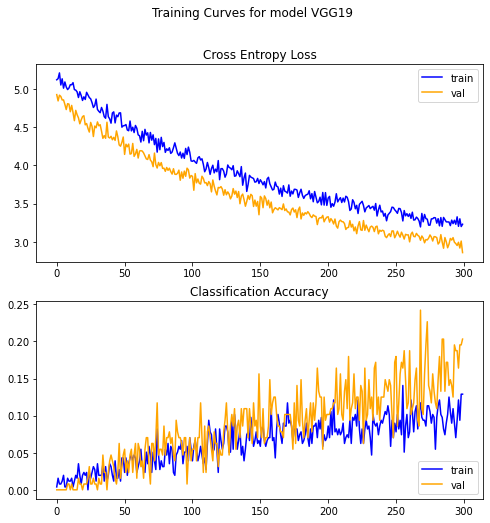


Test set evaluation metrics
10/10 [==============================] - 0s 31ms/step - loss: 2.9883 - accuracy: 0.1695
loss: 2.99
accuracy: 0.17


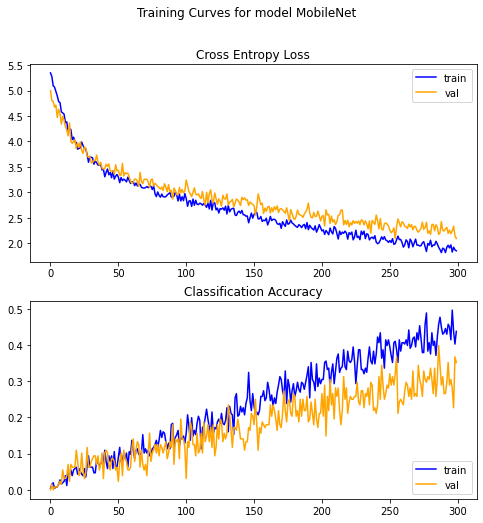


Test set evaluation metrics
10/10 [==============================] - 2s 197ms/step - loss: 2.2652 - accuracy: 0.3031
loss: 2.27
accuracy: 0.30


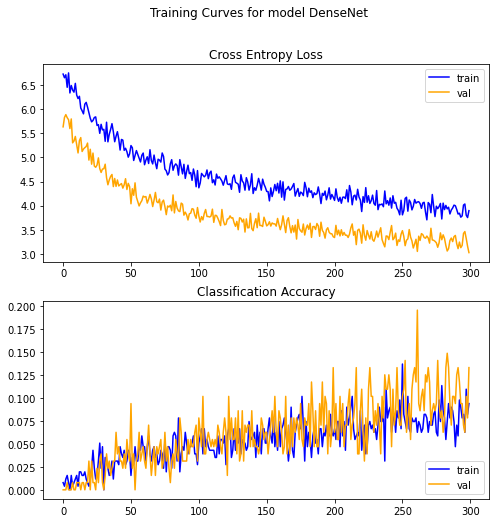


Test set evaluation metrics
10/10 [==============================] - 0s 31ms/step - loss: 3.1539 - accuracy: 0.1063
loss: 3.15
accuracy: 0.11


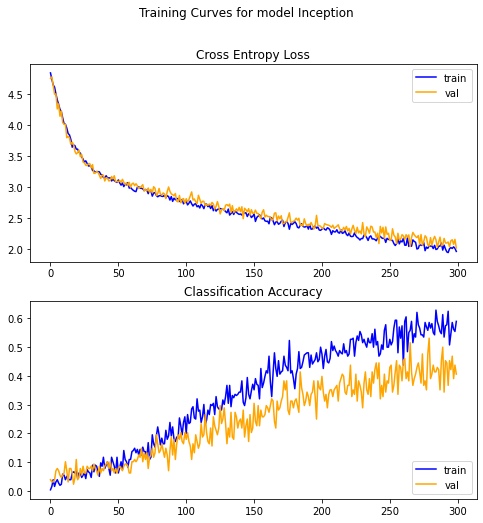


Test set evaluation metrics
10/10 [==============================] - 6s 596ms/step - loss: 2.0682 - accuracy: 0.4250
loss: 2.07
accuracy: 0.43


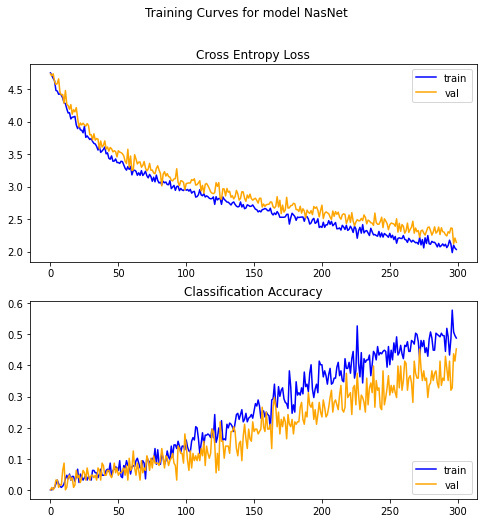


Test set evaluation metrics
10/10 [==============================] - 3s 330ms/step - loss: 2.2635 - accuracy: 0.3875
loss: 2.26
accuracy: 0.39


In [ ]:
(compiled_models, histories) = test_default_models()

for i in range(len(histories)):
  model_report(compiled_models[i], histories[i], datasets[datasetIndex[i]][2], modelNames[i], 10)


## Testing learning rate.
Τωρα απο τα παραπάνω μοντέλα είδαμε οτι την καλύτερη απόδοση έχει το Inception οποτε ασχολούμαστε με αυτο στην συνέχεια.
Μεταβαλλουμε τιμές του Learning rate και κοιτάμε πως επιδράει αυτό στην απόδοση του δικτύου.

In [ ]:
# testing on inception 

def test_learning_rate():
  histories = []
  compiled_models = []
  mod = models[4]
  for i in l_rate:
    mymodel=init_model(mod, extra_layers=2, base_train=True, finetune_layers=4, learning_rate=i, summary=False)
    history = train_model(mymodel, datasets[2][1] , datasets[2][0], epochs=100)
    histories.append(history)
    compiled_models.append(mymodel)
  
  return(compiled_models, histories)

Train for 2 steps, validate for 1 steps
Epoch 1/100
2/2 [==============================] - 18s 9s/step - loss: 4.6552 - accuracy: 0.0000e+00 - val_loss: 4.5665 - val_accuracy: 0.0000e+00
Epoch 2/100
2/2 [==============================] - 2s 1s/step - loss: 4.5240 - accuracy: 0.0039 - val_loss: 4.4309 - val_accuracy: 0.0078
Epoch 3/100
2/2 [==============================] - 2s 1s/step - loss: 4.3749 - accuracy: 0.0117 - val_loss: 4.3007 - val_accuracy: 0.0312
Epoch 4/100
2/2 [==============================] - 2s 1s/step - loss: 4.2713 - accuracy: 0.0156 - val_loss: 4.2121 - val_accuracy: 0.0391
Epoch 5/100
2/2 [==============================] - 2s 1s/step - loss: 4.1272 - accuracy: 0.0742 - val_loss: 4.0388 - val_accuracy: 0.0703
Epoch 6/100
2/2 [==============================] - 2s 1s/step - loss: 4.0175 - accuracy: 0.1055 - val_loss: 3.8895 - val_accuracy: 0.0938
Epoch 7/100
2/2 [==============================] - 2s 1s/step - loss: 3.8956 - accuracy: 0.1641 - val_loss: 3.9089 - val_ac

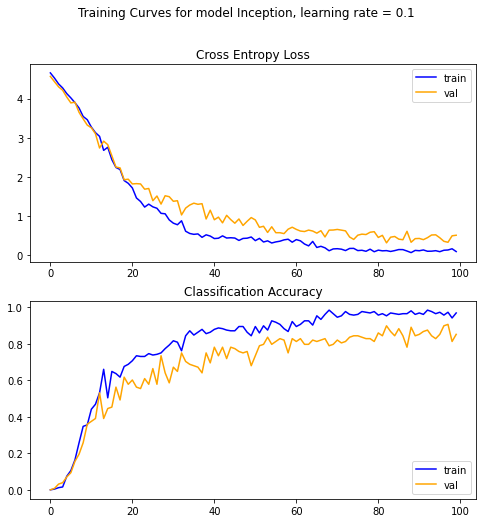


Test set evaluation metrics
10/10 [==============================] - 3s 280ms/step - loss: 1.0824 - accuracy: 0.8273
loss: 1.08
accuracy: 0.83


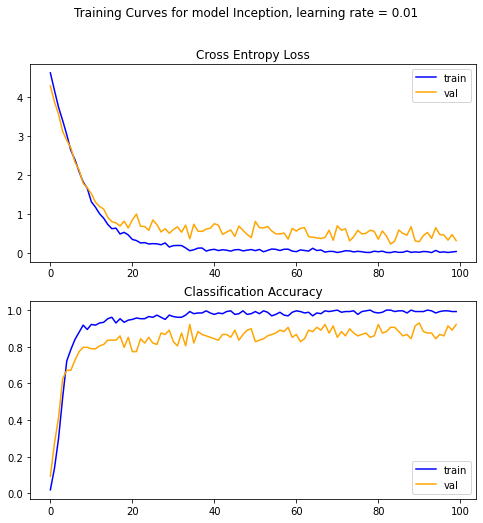


Test set evaluation metrics
10/10 [==============================] - 3s 279ms/step - loss: 0.9034 - accuracy: 0.8625
loss: 0.90
accuracy: 0.86


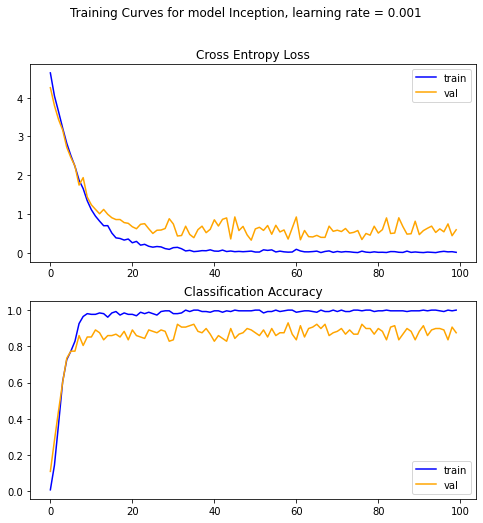


Test set evaluation metrics
10/10 [==============================] - 3s 281ms/step - loss: 0.8207 - accuracy: 0.8594
loss: 0.82
accuracy: 0.86


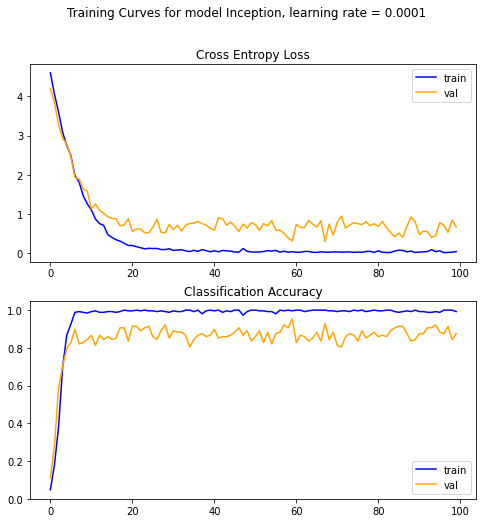


Test set evaluation metrics
10/10 [==============================] - 3s 279ms/step - loss: 0.7153 - accuracy: 0.8602
loss: 0.72
accuracy: 0.86


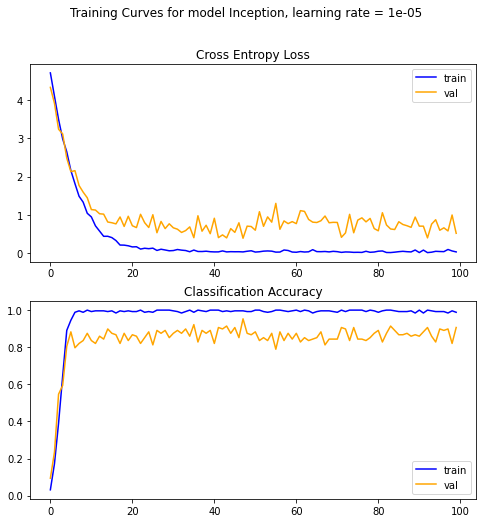


Test set evaluation metrics
10/10 [==============================] - 3s 279ms/step - loss: 0.7328 - accuracy: 0.8703
loss: 0.73
accuracy: 0.87


In [ ]:
(compiled_models, histories) = test_learning_rate()

for i in range(len(histories)):
  model_report(compiled_models[i], histories[i], datasets[2][2], 'Inception, learning rate = '+str(l_rate[i]) , 10)

## Testing : μεθοδοι μάθησης.
Εφαρμόζουμε τις τρείς διαφορετικές μεθόδους μάθησης όπως αναφέρονται στην εκφώνηση.

In [ ]:
# testing on inception 

def test_learning_method():
  histories = []

  modelNoTrain = init_model(inception_model, extra_layers=3, base_train=False, finetune_layers=0, learning_rate=0.0001 , summary=False)
  modelSomeTrain = init_model(inception_model, extra_layers=3, base_train=False, finetune_layers=3, learning_rate=0.0001 , summary=False)
  modelAllTrain = init_model(inception_model, extra_layers=3, base_train=True, finetune_layers=0, learning_rate=0.0001 , summary=False)

  history = train_model(modelNoTrain, datasets[2][1] , datasets[2][0], epochs=100)
  histories.append(history)

  history = train_model(modelSomeTrain, datasets[2][1] , datasets[2][0], epochs=100)
  histories.append(history)

  history = train_model(modelAllTrain, datasets[2][1] , datasets[2][0], epochs=100)
  histories.append(history)

  compiled_models = [modelNoTrain, modelSomeTrain, modelAllTrain]
  return(compiled_models, histories)



Train for 2 steps, validate for 1 steps
Epoch 1/100
2/2 [==============================] - 9s 5s/step - loss: 4.6421 - accuracy: 0.0078 - val_loss: 4.5974 - val_accuracy: 0.0156
Epoch 2/100
2/2 [==============================] - 1s 582ms/step - loss: 4.5728 - accuracy: 0.0312 - val_loss: 4.5537 - val_accuracy: 0.0156
Epoch 3/100
2/2 [==============================] - 1s 537ms/step - loss: 4.4667 - accuracy: 0.0430 - val_loss: 4.4328 - val_accuracy: 0.0547
Epoch 4/100
2/2 [==============================] - 1s 537ms/step - loss: 4.4098 - accuracy: 0.0312 - val_loss: 4.3626 - val_accuracy: 0.0703
Epoch 5/100
2/2 [==============================] - 1s 538ms/step - loss: 4.3374 - accuracy: 0.0586 - val_loss: 4.3083 - val_accuracy: 0.0547
Epoch 6/100
2/2 [==============================] - 1s 551ms/step - loss: 4.2736 - accuracy: 0.0469 - val_loss: 4.2867 - val_accuracy: 0.0781
Epoch 7/100
2/2 [==============================] - 1s 516ms/step - loss: 4.2319 - accuracy: 0.0547 - val_loss: 4.2167

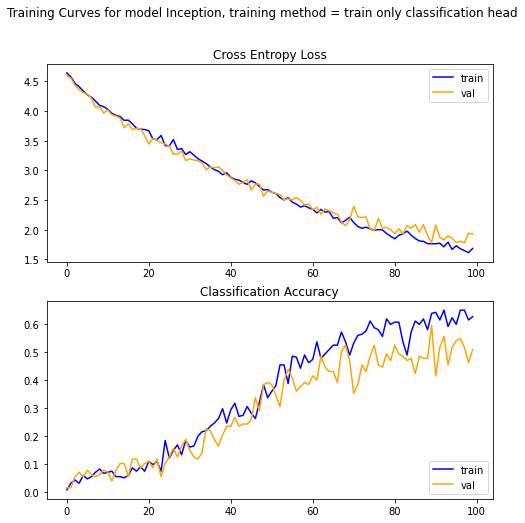


Test set evaluation metrics
10/10 [==============================] - 3s 283ms/step - loss: 1.0116 - accuracy: 0.8016
loss: 1.01
accuracy: 0.80


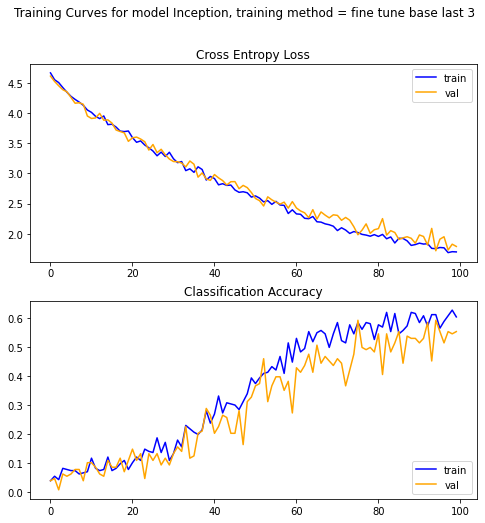


Test set evaluation metrics
10/10 [==============================] - 3s 282ms/step - loss: 0.9927 - accuracy: 0.8125
loss: 0.99
accuracy: 0.81


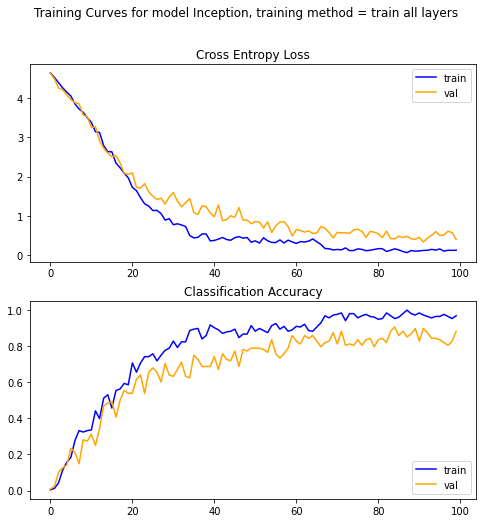


Test set evaluation metrics
10/10 [==============================] - 3s 282ms/step - loss: 0.5703 - accuracy: 0.8430
loss: 0.57
accuracy: 0.84


In [ ]:
(compiled_models, histories) = test_learning_method()
train_method=['train only classification head','fine tune base last 3 ','train all layers']
for i in range(len(histories)):
  model_report(compiled_models[i], histories[i], datasets[2][2], 'Inception, training method = ' + train_method[i] , 10)

##Testing : extra layers.
Μεταβάλλουμε τον αριθμό των Layers για το classification head.

In [ ]:
def test_extra_layers():
  histories = []
  compiled_models = []
  mod = models[4]
  for i in additional_layers:
    mymodel=init_model(mod, extra_layers=i, base_train=True, finetune_layers=4, learning_rate=0.0001, summary=False)
    history = train_model(mymodel, datasets[2][1] , datasets[2][0], epochs=100)
    histories.append(history)
    compiled_models.append(mymodel)
  
  return(compiled_models, histories)

Train for 2 steps, validate for 1 steps
Epoch 1/100
2/2 [==============================] - 18s 9s/step - loss: 4.8101 - accuracy: 0.0273 - val_loss: 4.8342 - val_accuracy: 0.0078
Epoch 2/100
2/2 [==============================] - 2s 1s/step - loss: 4.6013 - accuracy: 0.0391 - val_loss: 4.5133 - val_accuracy: 0.0312
Epoch 3/100
2/2 [==============================] - 2s 1s/step - loss: 4.2968 - accuracy: 0.0703 - val_loss: 4.1909 - val_accuracy: 0.0938
Epoch 4/100
2/2 [==============================] - 2s 1s/step - loss: 4.0826 - accuracy: 0.1250 - val_loss: 3.8920 - val_accuracy: 0.1406
Epoch 5/100
2/2 [==============================] - 2s 1s/step - loss: 3.8046 - accuracy: 0.2031 - val_loss: 3.6571 - val_accuracy: 0.2734
Epoch 6/100
2/2 [==============================] - 2s 1s/step - loss: 3.5968 - accuracy: 0.2930 - val_loss: 3.3059 - val_accuracy: 0.3047
Epoch 7/100
2/2 [==============================] - 2s 1s/step - loss: 3.2901 - accuracy: 0.3438 - val_loss: 3.1639 - val_accuracy: 

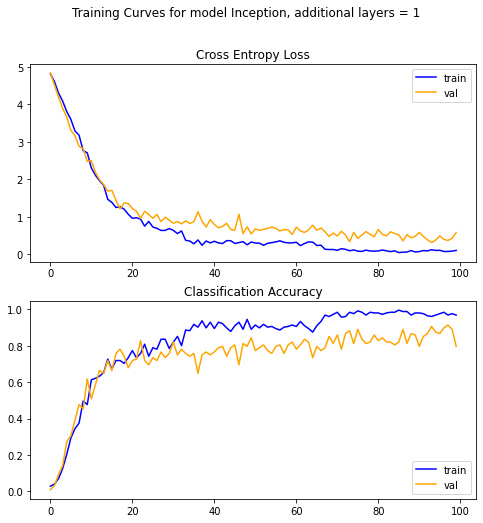


Test set evaluation metrics
10/10 [==============================] - 3s 282ms/step - loss: 0.4436 - accuracy: 0.8859
loss: 0.44
accuracy: 0.89


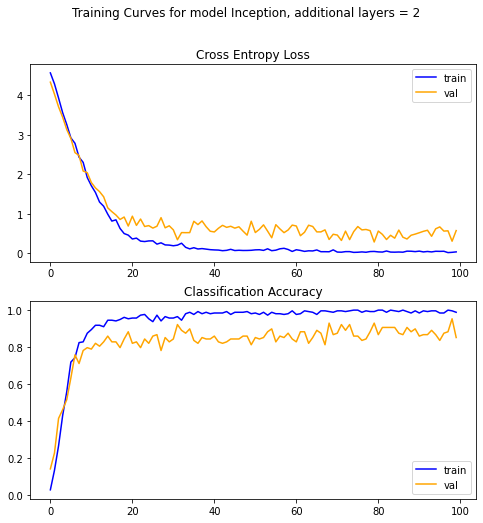


Test set evaluation metrics
10/10 [==============================] - 3s 282ms/step - loss: 0.4869 - accuracy: 0.8922
loss: 0.49
accuracy: 0.89


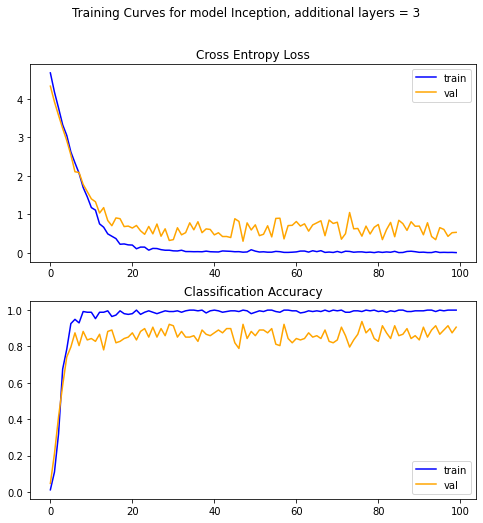


Test set evaluation metrics
10/10 [==============================] - 3s 283ms/step - loss: 0.5445 - accuracy: 0.8906
loss: 0.54
accuracy: 0.89


In [ ]:
(compiled_models, histories) = test_extra_layers()

for i in range(len(histories)):
  model_report(compiled_models[i], histories[i], datasets[2][2], 'Inception, additional layers = ' + str(additional_layers[i]) , 10)

##Testing : Fine Tuning
Μεταβάλλουμε τον αριθμό των layers του προεκπαιδευμένου μοντέλου που συνέχιζουν να είναι trainable μαζι με την κεφαληή ταξινόμησης

In [ ]:
def test_fine_tuning():
  histories = []
  compiled_models = []
  mod = models[4]
  for i in fine_tune_last:
    mymodel=init_model(mod, extra_layers=3, base_train=False, finetune_layers=i, learning_rate=0.0001, summary=False)
    history = train_model(mymodel, datasets[2][1] , datasets[2][0], epochs=200)
    histories.append(history)
    compiled_models.append(mymodel)
  
  return(compiled_models, histories)

Train for 2 steps, validate for 1 steps
Epoch 1/200
2/2 [==============================] - 10s 5s/step - loss: 4.6451 - accuracy: 0.0039 - val_loss: 4.6534 - val_accuracy: 0.0000e+00
Epoch 2/200
2/2 [==============================] - 1s 560ms/step - loss: 4.5777 - accuracy: 0.0156 - val_loss: 4.6263 - val_accuracy: 0.0000e+00
Epoch 3/200
2/2 [==============================] - 1s 514ms/step - loss: 4.5383 - accuracy: 0.0234 - val_loss: 4.5304 - val_accuracy: 0.0078
Epoch 4/200
2/2 [==============================] - 1s 539ms/step - loss: 4.4612 - accuracy: 0.0234 - val_loss: 4.5241 - val_accuracy: 0.0078
Epoch 5/200
2/2 [==============================] - 1s 540ms/step - loss: 4.4185 - accuracy: 0.0586 - val_loss: 4.3963 - val_accuracy: 0.0391
Epoch 6/200
2/2 [==============================] - 1s 523ms/step - loss: 4.3659 - accuracy: 0.0469 - val_loss: 4.3629 - val_accuracy: 0.0469
Epoch 7/200
2/2 [==============================] - 1s 542ms/step - loss: 4.2803 - accuracy: 0.0742 - val_los

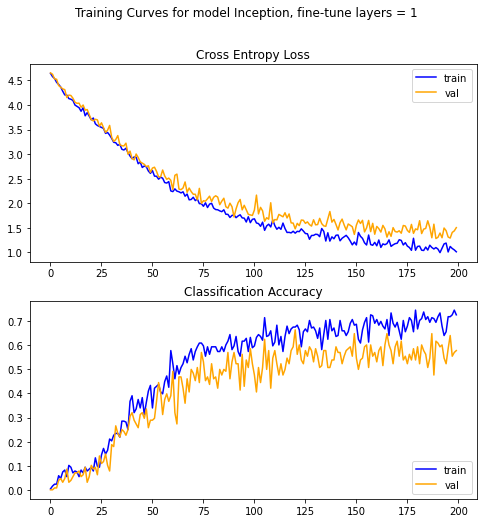


Test set evaluation metrics
10/10 [==============================] - 3s 279ms/step - loss: 1.4726 - accuracy: 0.5484
loss: 1.47
accuracy: 0.55


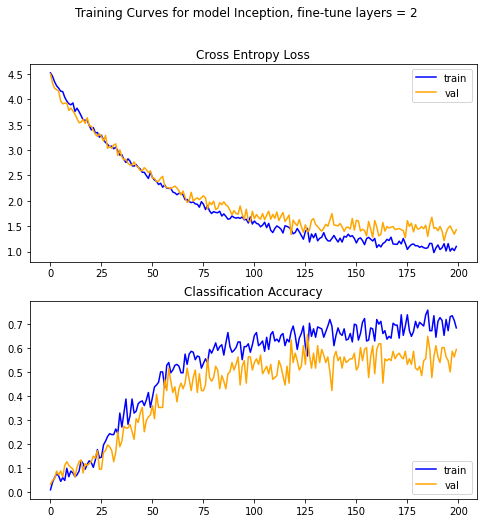


Test set evaluation metrics
10/10 [==============================] - 3s 280ms/step - loss: 1.3274 - accuracy: 0.5898
loss: 1.33
accuracy: 0.59


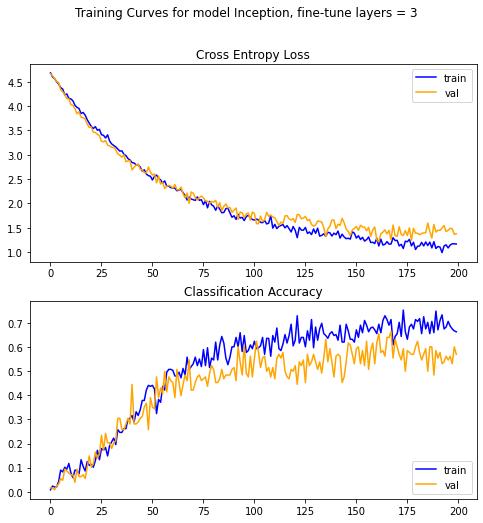


Test set evaluation metrics
10/10 [==============================] - 3s 283ms/step - loss: 1.4014 - accuracy: 0.5859
loss: 1.40
accuracy: 0.59


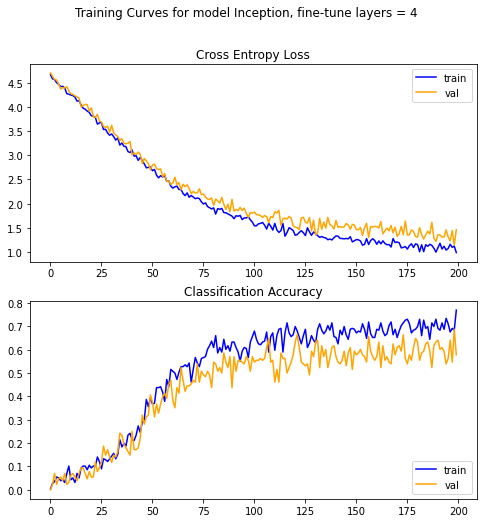


Test set evaluation metrics
10/10 [==============================] - 3s 281ms/step - loss: 1.3904 - accuracy: 0.5938
loss: 1.39
accuracy: 0.59


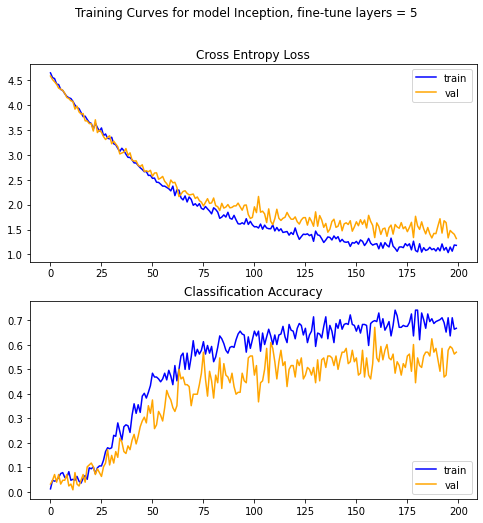


Test set evaluation metrics
10/10 [==============================] - 3s 280ms/step - loss: 1.5240 - accuracy: 0.5430
loss: 1.52
accuracy: 0.54


In [ ]:
(compiled_models, histories) = test_fine_tuning()

for i in range(len(histories)):
  model_report(compiled_models[i], histories[i], datasets[2][2], 'Inception, fine-tune layers = ' + str(fine_tune_last[i]) , 10)

##Βελτισοποιημενα μοντέλα

Μοντέλο Inception

Train for 2 steps, validate for 1 steps
Epoch 1/200
2/2 [==============================] - 12s 6s/step - loss: 4.5667 - accuracy: 0.0352 - val_loss: 4.2510 - val_accuracy: 0.0625
Epoch 2/200
2/2 [==============================] - 4s 2s/step - loss: 4.0486 - accuracy: 0.1914 - val_loss: 3.7704 - val_accuracy: 0.2812
Epoch 3/200
2/2 [==============================] - 4s 2s/step - loss: 3.6015 - accuracy: 0.4023 - val_loss: 3.4600 - val_accuracy: 0.4609
Epoch 4/200
2/2 [==============================] - 4s 2s/step - loss: 3.2218 - accuracy: 0.6914 - val_loss: 3.0465 - val_accuracy: 0.7109
Epoch 5/200
2/2 [==============================] - 4s 2s/step - loss: 2.8441 - accuracy: 0.8203 - val_loss: 2.6958 - val_accuracy: 0.7422
Epoch 6/200
2/2 [==============================] - 4s 2s/step - loss: 2.4491 - accuracy: 0.9141 - val_loss: 2.3694 - val_accuracy: 0.8359
Epoch 7/200
2/2 [==============================] - 4s 2s/step - loss: 2.0253 - accuracy: 0.9648 - val_loss: 2.0337 - val_accuracy: 

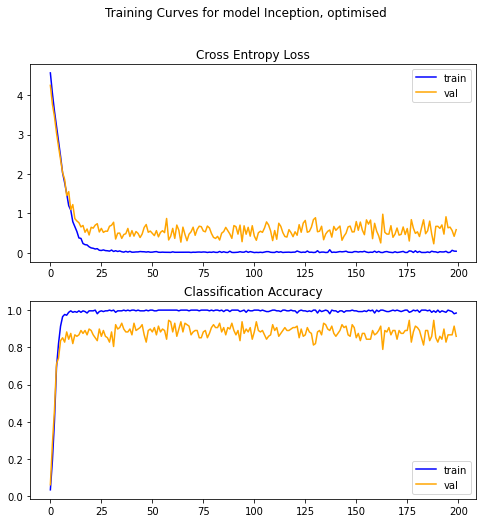


Test set evaluation metrics
10/10 [==============================] - 5s 470ms/step - loss: 0.6405 - accuracy: 0.8750
loss: 0.64
accuracy: 0.88


In [ ]:
modelBest = init_model(inception_model, extra_layers=3, base_train=True, finetune_layers=0, learning_rate=0.0001, summary=False)
history = train_model(modelBest, datasets[2][1] , datasets[2][0], epochs=200)

model_report(modelBest, history, datasets[2][2], 'Inception, optimised', 10)

Βελτιστοποιημένο μοντέλο VGG16

Train for 2 steps, validate for 1 steps
Epoch 1/200
2/2 [==============================] - 3s 1s/step - loss: 4.5953 - accuracy: 0.0039 - val_loss: 4.4802 - val_accuracy: 0.0781
Epoch 2/200
2/2 [==============================] - 0s 82ms/step - loss: 4.4863 - accuracy: 0.0352 - val_loss: 4.3883 - val_accuracy: 0.0859
Epoch 3/200
2/2 [==============================] - 0s 84ms/step - loss: 4.3683 - accuracy: 0.0664 - val_loss: 4.2656 - val_accuracy: 0.0625
Epoch 4/200
2/2 [==============================] - 0s 81ms/step - loss: 4.2357 - accuracy: 0.0898 - val_loss: 4.1724 - val_accuracy: 0.0859
Epoch 5/200
2/2 [==============================] - 0s 86ms/step - loss: 4.2838 - accuracy: 0.0586 - val_loss: 4.0021 - val_accuracy: 0.0781
Epoch 6/200
2/2 [==============================] - 0s 81ms/step - loss: 4.0925 - accuracy: 0.0586 - val_loss: 3.9249 - val_accuracy: 0.0469
Epoch 7/200
2/2 [==============================] - 0s 81ms/step - loss: 4.0416 - accuracy: 0.0586 - val_loss: 3.8043 - val

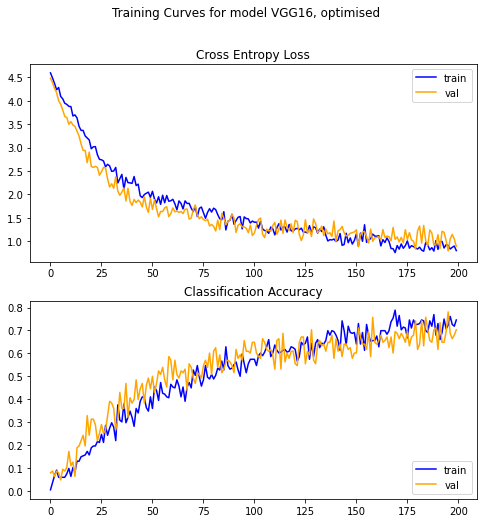


Test set evaluation metrics
10/10 [==============================] - 0s 20ms/step - loss: 1.0119 - accuracy: 0.6930
loss: 1.01
accuracy: 0.69


In [ ]:
modelBest = init_model(VGG16_MODEL, extra_layers=3, base_train=True, finetune_layers=0, learning_rate=0.0001, summary=False)
history = train_model(modelBest, datasets[0][1] , datasets[0][0], epochs=200)

model_report(modelBest, history, datasets[0][2], 'VGG16, optimised', 10)

Βελτιστοποιημένο μοντέλο VGG19

Train for 2 steps, validate for 1 steps
Epoch 1/200
2/2 [==============================] - 1s 690ms/step - loss: 4.7134 - accuracy: 0.0312 - val_loss: 4.5833 - val_accuracy: 0.0156
Epoch 2/200
2/2 [==============================] - 0s 100ms/step - loss: 4.5939 - accuracy: 0.0312 - val_loss: 4.4545 - val_accuracy: 0.0547
Epoch 3/200
2/2 [==============================] - 0s 98ms/step - loss: 4.5735 - accuracy: 0.0352 - val_loss: 4.4266 - val_accuracy: 0.0547
Epoch 4/200
2/2 [==============================] - 0s 94ms/step - loss: 4.4850 - accuracy: 0.0625 - val_loss: 4.3329 - val_accuracy: 0.0547
Epoch 5/200
2/2 [==============================] - 0s 96ms/step - loss: 4.4982 - accuracy: 0.0352 - val_loss: 4.2453 - val_accuracy: 0.0547
Epoch 6/200
2/2 [==============================] - 0s 94ms/step - loss: 4.3260 - accuracy: 0.0625 - val_loss: 4.1675 - val_accuracy: 0.0781
Epoch 7/200
2/2 [==============================] - 0s 94ms/step - loss: 4.2931 - accuracy: 0.0391 - val_loss: 4.0743 -

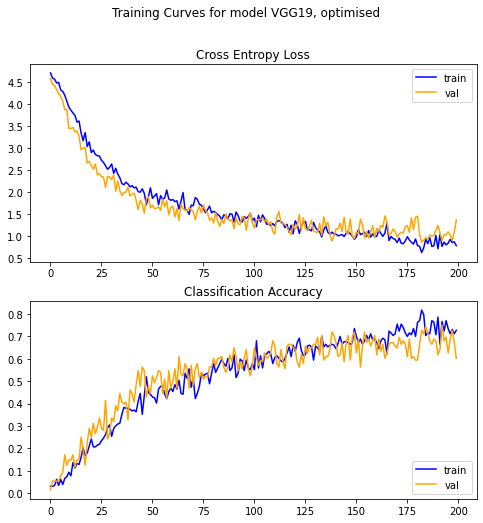


Test set evaluation metrics
10/10 [==============================] - 0s 23ms/step - loss: 1.1324 - accuracy: 0.6672
loss: 1.13
accuracy: 0.67


In [ ]:
modelBest = init_model(VGG19_MODEL, extra_layers=3, base_train=True, finetune_layers=0, learning_rate=0.0001, summary=False)
history = train_model(modelBest, datasets[0][1] , datasets[0][0], epochs=200)

model_report(modelBest, history, datasets[0][2], 'VGG19, optimised', 10)

Βελτισοποιημένο MobileNet

Train for 2 steps, validate for 1 steps
Epoch 1/200
2/2 [==============================] - 7s 3s/step - loss: 4.8662 - accuracy: 0.0000e+00 - val_loss: 4.8448 - val_accuracy: 0.0000e+00
Epoch 2/200
2/2 [==============================] - 2s 804ms/step - loss: 4.7055 - accuracy: 0.0039 - val_loss: 4.7726 - val_accuracy: 0.0000e+00
Epoch 3/200
2/2 [==============================] - 2s 771ms/step - loss: 4.6011 - accuracy: 0.0039 - val_loss: 4.6820 - val_accuracy: 0.0078
Epoch 4/200
2/2 [==============================] - 2s 824ms/step - loss: 4.5329 - accuracy: 0.0273 - val_loss: 4.7326 - val_accuracy: 0.0078
Epoch 5/200
2/2 [==============================] - 2s 819ms/step - loss: 4.3171 - accuracy: 0.0430 - val_loss: 4.6026 - val_accuracy: 0.0156
Epoch 6/200
2/2 [==============================] - 2s 824ms/step - loss: 4.2833 - accuracy: 0.0430 - val_loss: 4.5465 - val_accuracy: 0.0156
Epoch 7/200
2/2 [==============================] - 2s 842ms/step - loss: 4.1158 - accuracy: 0.0820 - val_

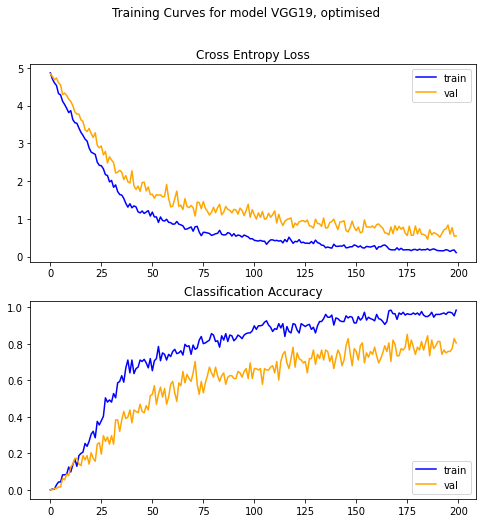


Test set evaluation metrics
10/10 [==============================] - 1s 137ms/step - loss: 0.6197 - accuracy: 0.8070
loss: 0.62
accuracy: 0.81


In [ ]:
modelBest = init_model(mobilenet_MODEL, extra_layers=3, base_train=True, finetune_layers=0, learning_rate=0.0001, summary=False)
history = train_model(modelBest, datasets[1][1] , datasets[1][0], epochs=200)

model_report(modelBest, history, datasets[1][2], 'VGG19, optimised', 10)

Βελτισοποιημένο DenseNet

Train for 2 steps, validate for 1 steps
Epoch 1/200
2/2 [==============================] - 14s 7s/step - loss: 4.9497 - accuracy: 0.0195 - val_loss: 4.6511 - val_accuracy: 0.0078
Epoch 2/200
2/2 [==============================] - 0s 97ms/step - loss: 5.0170 - accuracy: 0.0117 - val_loss: 4.6688 - val_accuracy: 0.0469
Epoch 3/200
2/2 [==============================] - 0s 94ms/step - loss: 4.8440 - accuracy: 0.0352 - val_loss: 4.4281 - val_accuracy: 0.0391
Epoch 4/200
2/2 [==============================] - 0s 91ms/step - loss: 4.8366 - accuracy: 0.0156 - val_loss: 4.4588 - val_accuracy: 0.0547
Epoch 5/200
2/2 [==============================] - 0s 93ms/step - loss: 4.6524 - accuracy: 0.0195 - val_loss: 4.5041 - val_accuracy: 0.0547
Epoch 6/200
2/2 [==============================] - 0s 96ms/step - loss: 4.6819 - accuracy: 0.0273 - val_loss: 4.4152 - val_accuracy: 0.0547
Epoch 7/200
2/2 [==============================] - 0s 92ms/step - loss: 4.5677 - accuracy: 0.0352 - val_loss: 4.2157 - va

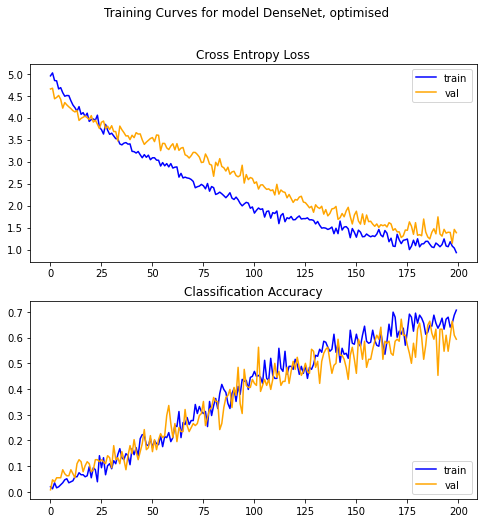


Test set evaluation metrics
10/10 [==============================] - 0s 23ms/step - loss: 1.3342 - accuracy: 0.5977
loss: 1.33
accuracy: 0.60


In [ ]:
modelBest = init_model(densenet_model, extra_layers=3, base_train=True, finetune_layers=0, learning_rate=0.0001, summary=False)
history = train_model(modelBest, datasets[0][1] , datasets[0][0], epochs=200)

model_report(modelBest, history, datasets[0][2], 'DenseNet, optimised', 10)

Βελτισοποιημένο NasNet

Train for 2 steps, validate for 1 steps
Epoch 1/200
2/2 [==============================] - 30s 15s/step - loss: 4.5618 - accuracy: 0.0273 - val_loss: 4.6357 - val_accuracy: 0.0312
Epoch 2/200
2/2 [==============================] - 3s 1s/step - loss: 4.5289 - accuracy: 0.0352 - val_loss: 4.5325 - val_accuracy: 0.0156
Epoch 3/200
2/2 [==============================] - 3s 1s/step - loss: 4.5083 - accuracy: 0.0508 - val_loss: 4.4151 - val_accuracy: 0.0234
Epoch 4/200
2/2 [==============================] - 3s 1s/step - loss: 4.3898 - accuracy: 0.0430 - val_loss: 4.4036 - val_accuracy: 0.0547
Epoch 5/200
2/2 [==============================] - 3s 1s/step - loss: 4.3153 - accuracy: 0.0469 - val_loss: 4.3976 - val_accuracy: 0.0703
Epoch 6/200
2/2 [==============================] - 3s 1s/step - loss: 4.2336 - accuracy: 0.0742 - val_loss: 4.3484 - val_accuracy: 0.0469
Epoch 7/200
2/2 [==============================] - 3s 1s/step - loss: 4.1695 - accuracy: 0.0742 - val_loss: 4.2319 - val_accuracy:

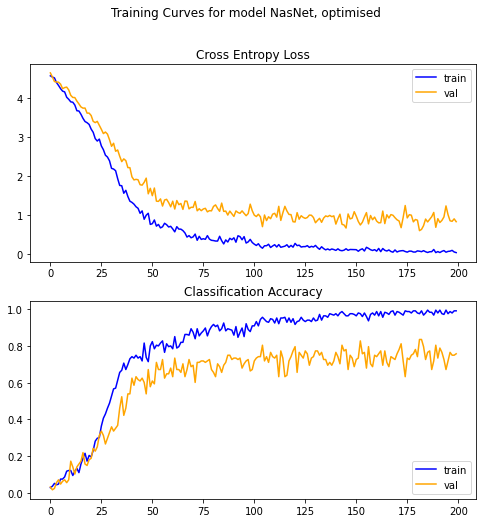


Test set evaluation metrics
10/10 [==============================] - 2s 230ms/step - loss: 0.8958 - accuracy: 0.7406
loss: 0.90
accuracy: 0.74


In [ ]:
modelBest = init_model(NasNet, extra_layers=3, base_train=True, finetune_layers=0, learning_rate=0.0001, summary=False)
history = train_model(modelBest, datasets[1][1] , datasets[1][0], epochs=200)

model_report(modelBest, history, datasets[1][2], 'NasNet, optimised', 10)